# Communication Comparison: Queue.Queue vs Shared Dict

This notebook compares two communication approaches:
- **Shared Dict**: Using a shared dictionary with locks for synchronization
- **Queue.Queue**: Using queues for message passing (no shared memory)

Both approaches implement federated learning with model aggregation, but differ in their communication mechanisms.


## Imports


In [1]:
import time
import math
import pickle
import threading
import queue
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import defaultdict

%matplotlib inline
print("✓ Imports complete")


✓ Imports complete


## Model Definition


In [2]:
class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.movie_emb = nn.Embedding(n_movies, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),
            nn.ReLU()
        )
    
    def forward(self, u_idx, m_idx):
        u = F.dropout(self.user_emb(u_idx), p=0.4, training=self.training)
        m = F.dropout(self.movie_emb(m_idx), p=0.4, training=self.training)
        return self.mlp(torch.cat([u, m], dim=1)).squeeze()

print("✓ Model class defined")


✓ Model class defined


## Helper Functions


In [3]:
def weighted_average_state_dicts(state_dicts, weights):
    """Weighted average of state dicts based on test losses"""
    total_weight = sum(weights)
    if total_weight == 0:
        weights = [1.0 / len(weights)] * len(weights)
    else:
        weights = [w / total_weight for w in weights]
    
    avg = {}
    for k in state_dicts[0].keys():
        stacked = torch.stack([sd[k].cpu() for sd in state_dicts], dim=0)
        avg[k] = sum(w * stacked[i] for i, w in enumerate(weights))
    return avg

def calculate_state_dict_size(state_dict):
    """Calculate the size of a state dict in bytes"""
    total_size = 0
    for key, value in state_dict.items():
        # Each parameter tensor
        total_size += value.numel() * value.element_size()
    return total_size

print("✓ Helper functions defined")


✓ Helper functions defined


## Configuration


In [4]:
class Config:
    num_workers = 5
    local_epochs = 10
    comm_rounds = 3
    batch_size = 64
    lr = 1e-3
    emb_dim = 16
    hidden = 16
    dropout = 0.1
    seed = 42
    log_every = 2
    agg_timeout = 30.0
    splits_file = "splits.pt"

cfg = Config()
total_epochs = cfg.comm_rounds * cfg.local_epochs

print(f"Configuration:")
print(f"  Workers: {cfg.num_workers}")
print(f"  Communication Rounds: {cfg.comm_rounds}")
print(f"  Local Epochs per Round: {cfg.local_epochs}")
print(f"  Total Epochs: {total_epochs}")
print(f"  Batch Size: {cfg.batch_size}")
print(f"  Learning Rate: {cfg.lr}")


Configuration:
  Workers: 5
  Communication Rounds: 3
  Local Epochs per Round: 10
  Total Epochs: 30
  Batch Size: 64
  Learning Rate: 0.001


## Load Data Splits


In [5]:
# Load data splits
tensors_list = torch.load(cfg.splits_file, weights_only=False)
if not isinstance(tensors_list, list) or len(tensors_list) == 0:
    raise RuntimeError(f"{cfg.splits_file} not found or invalid.")

num_workers = min(cfg.num_workers, len(tensors_list))
print(f"✓ Loaded {len(tensors_list)} splits, using {num_workers} workers")

# Calculate global dimensions
global_n_users = max(
    max(int(t["X_train"][:, 0].max().item()), int(t["X_test"][:, 0].max().item()))
    for t in tensors_list
) + 1
global_n_movies = max(
    max(int(t["X_train"][:, 1].max().item()), int(t["X_test"][:, 1].max().item()))
    for t in tensors_list
) + 1

print(f"✓ Global dimensions: {global_n_users} users, {global_n_movies} movies")


✓ Loaded 5 splits, using 5 workers
✓ Global dimensions: 1000 users, 11459 movies


## Approach 1: Shared Dict (with Communication Tracking)


In [6]:
# Shared Dict worker function with communication tracking
def worker_proc_shared_dict(worker_id, tensors_dict, shared, shared_lock, global_n_users, global_n_movies, comm_stats):
    torch.manual_seed(cfg.seed + worker_id)

    X_train, y_train = tensors_dict["X_train"], tensors_dict["y_train"].float()
    X_test, y_test = tensors_dict["X_test"], tensors_dict["y_test"].float()
    
    model = CollabFiltering(global_n_users, global_n_movies, cfg.emb_dim, cfg.hidden, cfg.dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    loss_fn = nn.MSELoss()
    
    tr_loader = DataLoader(
        TensorDataset(X_train[:, 0].long(), X_train[:, 1].long(), y_train),
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=0
    )
    te_loader = DataLoader(
        TensorDataset(X_test[:, 0].long(), X_test[:, 1].long(), y_test),
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=0
    )
    
    # Load global state if available
    with shared_lock:
        global_state = shared.get("global_state", None)
    if global_state is not None:
        try:
            model.load_state_dict(global_state)
            optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
        except Exception as e:
            print(f"[SD-W{worker_id}] failed to load initial global_state: {e}")
    
    history = []
    
    for round_idx in range(cfg.comm_rounds):
        best_rmse, best_test_loss, best_state = math.inf, math.inf, None
        
        for epoch in range(cfg.local_epochs):
            # Training
            model.train()
            losses = []
            for u, m, y in tr_loader:
                optimizer.zero_grad()
                preds = model(u, m)
                if preds.dim() == 0:
                    preds = preds.unsqueeze(0)
                y = y.view_as(preds)
                loss = loss_fn(preds, y)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            
            train_loss = sum(losses) / len(losses) if losses else 0.0
            train_rmse = math.sqrt(train_loss) if train_loss >= 0 else float("nan")
            
            # Validation
            model.eval()
            losses = []
            with torch.no_grad():
                for u, m, y in te_loader:
                    preds = model(u, m)
                    if preds.dim() == 0:
                        preds = preds.unsqueeze(0)
                    y = y.view_as(preds)
                    losses.append(loss_fn(preds, y).item())
            test_loss = sum(losses) / len(losses) if losses else 0.0
            test_rmse = math.sqrt(test_loss) if test_loss >= 0 else float("nan")
            
            history.append({
                "round": round_idx,
                "epoch_in_round": epoch,
                "global_epoch": round_idx * cfg.local_epochs + epoch,
                "train_loss": train_loss,
                "train_rmse": train_rmse,
                "test_loss": test_loss,
                "test_rmse": test_rmse
            })
            
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                best_test_loss = test_loss
                best_state = {k: v.clone().cpu() for k, v in model.state_dict().items()}
            
            if (epoch + 1) % cfg.log_every == 0:
                print(
                    f"[SD-W{worker_id}] R{round_idx} E{epoch+1}/{cfg.local_epochs} "
                    f"train_loss={train_loss:.4f} train_rmse={train_rmse:.4f} "
                    f"test_loss={test_loss:.4f} test_rmse={test_rmse:.4f}"
                )
        
        # Signal this worker's best for this round (with communication tracking)
        state_size = calculate_state_dict_size(best_state) if best_state is not None else 0
        comm_start = time.time()
        
        with shared_lock:
            shared[f"w{worker_id}_r{round_idx}_best"] = best_state
            shared[f"w{worker_id}_r{round_idx}_rmse"] = best_rmse
            shared[f"w{worker_id}_r{round_idx}_test_loss"] = best_test_loss
            shared[f"w{worker_id}_r{round_idx}_ready"] = True
        
        comm_time = time.time() - comm_start
        
        comm_stats["shared_dict"]["write_ops"] += 4  # 4 dictionary writes
        comm_stats["shared_dict"]["bytes_written"] += state_size + 32  # state dict + 3 floats
        comm_stats["shared_dict"]["write_time"] += comm_time
        comm_stats["shared_dict"]["sync_points"] += 1  # one lock acquisition
        
        # Wait for aggregated model
        agg_key = f"agg_r{round_idx}_state"
        waited = 0.0
        comm_start = time.time()
        read_attempts = 0
        
        while waited <= cfg.agg_timeout:
            read_attempts += 1
            with shared_lock:
                agg_state = shared.get(agg_key, None)
            if agg_state is not None:
                try:
                    agg_size = calculate_state_dict_size(agg_state)
                    model.load_state_dict(agg_state)
                    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
                    comm_time = time.time() - comm_start
                    
                    comm_stats["shared_dict"]["read_ops"] += read_attempts
                    comm_stats["shared_dict"]["bytes_read"] += agg_size * read_attempts  # each read attempt
                    comm_stats["shared_dict"]["read_time"] += comm_time
                    comm_stats["shared_dict"]["sync_points"] += read_attempts
                    
                    print(f"[SD-W{worker_id}] loaded aggregated model for round {round_idx}")
                except Exception as e:
                    print(f"[SD-W{worker_id}] failed to load agg: {e}")
                break
            time.sleep(0.2)
            waited += 0.2
        else:
            print(f"[SD-W{worker_id}] waited {cfg.agg_timeout}s for agg; continuing without it")
    
    with shared_lock:
        shared[f"w{worker_id}_final"] = history
        shared[f"w{worker_id}_done"] = True
    print(f"[SD-W{worker_id}] finished all rounds")

print("✓ Shared Dict worker function defined")


✓ Shared Dict worker function defined


In [7]:
# Shared Dict aggregator function with communication tracking
def aggregator_shared_dict(num_workers, shared, shared_lock, comm_stats):
    for r in range(cfg.comm_rounds):
        print(f"[SD-AGG] waiting for {num_workers} workers ready for round {r}...")
        
        # Wait for all workers
        wait_start = time.time()
        wait_attempts = 0
        
        while True:
            wait_attempts += 1
            with shared_lock:
                ready_count = sum(
                    1 for w in range(num_workers)
                    if shared.get(f"w{w}_r{r}_ready", False)
                )
            if ready_count >= num_workers:
                break
            time.sleep(0.2)
        
        wait_time = time.time() - wait_start
        comm_stats["shared_dict"]["sync_time"] += wait_time
        comm_stats["shared_dict"]["sync_points"] += wait_attempts
        
        # Read all worker states
        comm_start = time.time()
        with shared_lock:
            states = [shared[f"w{w}_r{r}_best"] for w in range(num_workers)]
            test_losses = [shared[f"w{w}_r{r}_test_loss"] for w in range(num_workers)]
            rmses = [shared[f"w{w}_r{r}_rmse"] for w in range(num_workers)]
        
        total_read_size = sum(calculate_state_dict_size(s) for s in states) + len(test_losses) * 8 + len(rmses) * 8
        comm_time = time.time() - comm_start
        
        comm_stats["shared_dict"]["read_ops"] += num_workers * 3  # 3 reads per worker
        comm_stats["shared_dict"]["bytes_read"] += total_read_size
        comm_stats["shared_dict"]["read_time"] += comm_time
        comm_stats["shared_dict"]["sync_points"] += 1
        
        weights = [1.0 / (tl + 1e-8) for tl in test_losses]
        agg_state = weighted_average_state_dicts(states, weights)
        agg_size = calculate_state_dict_size(agg_state)
        
        # Write aggregated state
        comm_start = time.time()
        with shared_lock:
            shared[f"agg_r{r}_state"] = agg_state
        comm_time = time.time() - comm_start
        
        comm_stats["shared_dict"]["write_ops"] += 1
        comm_stats["shared_dict"]["bytes_written"] += agg_size
        comm_stats["shared_dict"]["write_time"] += comm_time
        comm_stats["shared_dict"]["sync_points"] += 1
        
        print(
            f"[SD-AGG] published aggregated state for round {r} (weighted by test loss), "
            f"worker test_losses={test_losses}, rmses={rmses}"
        )
        
        with shared_lock:
            for w in range(num_workers):
                rk = f"w{w}_r{r}_ready"
                if rk in shared:
                    del shared[rk]
    
    print("[SD-AGG] Waiting for all workers to finish...")
    while True:
        with shared_lock:
            done_count = sum(
                1 for w in range(num_workers)
                if shared.get(f"w{w}_done", False)
            )
        if done_count >= num_workers:
            break
        time.sleep(0.2)
    
    print("[SD-AGG] Collecting worker histories...")
    all_candidates = []
    with shared_lock:
        for w in range(num_workers):
            history = shared.get(f"w{w}_final", [])
            print(f"[SD-AGG] Worker {w} history length: {len(history)}")
            if history:
                all_candidates.append({
                    "node": w,
                    "epoch_states": None,
                    "train_losses": [e["train_loss"] for e in history],
                    "test_losses": [e["test_loss"] for e in history],
                    "train_rmses": [e["train_rmse"] for e in history],
                    "test_rmses": [e["test_rmse"] for e in history],
                })
        
        shared["all_candidates_stage1"] = all_candidates
        shared["agg_done"] = True
    
    print(f"[SD-AGG] Collected histories from {len(all_candidates)} workers")
    return all_candidates

print("✓ Shared Dict aggregator function defined")


✓ Shared Dict aggregator function defined


## Approach 2: Queue.Queue (with Communication Tracking)


In [8]:
# Queue.Queue worker function with communication tracking
def worker_proc_queue(worker_id, tensors_dict, worker_to_agg_queue, agg_to_worker_queues, global_n_users, global_n_movies, comm_stats):
    torch.manual_seed(cfg.seed + worker_id)

    X_train, y_train = tensors_dict["X_train"], tensors_dict["y_train"].float()
    X_test, y_test = tensors_dict["X_test"], tensors_dict["y_test"].float()
    
    model = CollabFiltering(global_n_users, global_n_movies, cfg.emb_dim, cfg.hidden, cfg.dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    loss_fn = nn.MSELoss()
    
    tr_loader = DataLoader(
        TensorDataset(X_train[:, 0].long(), X_train[:, 1].long(), y_train),
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=0
    )
    te_loader = DataLoader(
        TensorDataset(X_test[:, 0].long(), X_test[:, 1].long(), y_test),
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=0
    )
    
    # Get initial global state if available (from queue)
    try:
        initial_msg = agg_to_worker_queues[worker_id].get(timeout=0.1)
        if initial_msg["type"] == "global_state":
            model.load_state_dict(initial_msg["state"])
            optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    except queue.Empty:
        pass
    
    history = []
    
    for round_idx in range(cfg.comm_rounds):
        best_rmse, best_test_loss, best_state = math.inf, math.inf, None
        
        for epoch in range(cfg.local_epochs):
            # Training
            model.train()
            losses = []
            for u, m, y in tr_loader:
                optimizer.zero_grad()
                preds = model(u, m)
                if preds.dim() == 0:
                    preds = preds.unsqueeze(0)
                y = y.view_as(preds)
                loss = loss_fn(preds, y)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            
            train_loss = sum(losses) / len(losses) if losses else 0.0
            train_rmse = math.sqrt(train_loss) if train_loss >= 0 else float("nan")
            
            # Validation
            model.eval()
            losses = []
            with torch.no_grad():
                for u, m, y in te_loader:
                    preds = model(u, m)
                    if preds.dim() == 0:
                        preds = preds.unsqueeze(0)
                    y = y.view_as(preds)
                    losses.append(loss_fn(preds, y).item())
            test_loss = sum(losses) / len(losses) if losses else 0.0
            test_rmse = math.sqrt(test_loss) if test_loss >= 0 else float("nan")
            
            history.append({
                "round": round_idx,
                "epoch_in_round": epoch,
                "global_epoch": round_idx * cfg.local_epochs + epoch,
                "train_loss": train_loss,
                "train_rmse": train_rmse,
                "test_loss": test_loss,
                "test_rmse": test_rmse
            })
            
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                best_test_loss = test_loss
                best_state = {k: v.clone().cpu() for k, v in model.state_dict().items()}
            
            if (epoch + 1) % cfg.log_every == 0:
                print(
                    f"[Q-W{worker_id}] R{round_idx} E{epoch+1}/{cfg.local_epochs} "
                    f"train_loss={train_loss:.4f} train_rmse={train_rmse:.4f} "
                    f"test_loss={test_loss:.4f} test_rmse={test_rmse:.4f}"
                )
        
        # Send worker's best state to aggregator (with communication tracking)
        state_size = calculate_state_dict_size(best_state) if best_state is not None else 0
        comm_start = time.time()
        
        msg = {
            "type": "worker_result",
            "worker_id": worker_id,
            "round": round_idx,
            "state": best_state,
            "rmse": best_rmse,
            "test_loss": best_test_loss
        }
        
        worker_to_agg_queue.put(msg)
        comm_time = time.time() - comm_start
        
        comm_stats["queue"]["write_ops"] += 1  # one queue put
        comm_stats["queue"]["bytes_written"] += state_size + 32  # state dict + 3 values
        comm_stats["queue"]["write_time"] += comm_time
        comm_stats["queue"]["messages_sent"] += 1
        
        # Wait for aggregated model from queue
        comm_start = time.time()
        try:
            agg_msg = agg_to_worker_queues[worker_id].get(timeout=cfg.agg_timeout)
            if agg_msg["type"] == "aggregated_state":
                agg_state = agg_msg["state"]
                agg_size = calculate_state_dict_size(agg_state)
                model.load_state_dict(agg_state)
                optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
                comm_time = time.time() - comm_start
                
                comm_stats["queue"]["read_ops"] += 1
                comm_stats["queue"]["bytes_read"] += agg_size
                comm_stats["queue"]["read_time"] += comm_time
                comm_stats["queue"]["messages_received"] += 1
                
                print(f"[Q-W{worker_id}] loaded aggregated model for round {round_idx}")
        except queue.Empty:
            print(f"[Q-W{worker_id}] timeout waiting for aggregated model for round {round_idx}")
    
    # Send final history to aggregator
    final_msg = {
        "type": "final_history",
        "worker_id": worker_id,
        "history": history
    }
    worker_to_agg_queue.put(final_msg)
    print(f"[Q-W{worker_id}] finished all rounds")

print("✓ Queue.Queue worker function defined")


✓ Queue.Queue worker function defined


In [9]:
# Queue.Queue aggregator function with communication tracking
def aggregator_queue(num_workers, worker_to_agg_queue, agg_to_worker_queues, comm_stats):
    for r in range(cfg.comm_rounds):
        print(f"[Q-AGG] waiting for {num_workers} workers ready for round {r}...")
        
        # Collect messages from all workers
        wait_start = time.time()
        worker_results = {}
        
        while len(worker_results) < num_workers:
            try:
                msg = worker_to_agg_queue.get(timeout=1.0)
                if msg["type"] == "worker_result" and msg["round"] == r:
                    worker_results[msg["worker_id"]] = msg
            except queue.Empty:
                continue
        
        wait_time = time.time() - wait_start
        comm_stats["queue"]["sync_time"] += wait_time
        comm_stats["queue"]["messages_received"] += num_workers
        comm_stats["queue"]["read_ops"] += num_workers
        
        # Calculate total bytes received
        total_bytes = sum(calculate_state_dict_size(wr["state"]) for wr in worker_results.values())
        total_bytes += num_workers * 32  # metadata
        comm_stats["queue"]["bytes_read"] += total_bytes
        
        states = [worker_results[w]["state"] for w in range(num_workers)]
        test_losses = [worker_results[w]["test_loss"] for w in range(num_workers)]
        rmses = [worker_results[w]["rmse"] for w in range(num_workers)]
        
        weights = [1.0 / (tl + 1e-8) for tl in test_losses]
        agg_state = weighted_average_state_dicts(states, weights)
        agg_size = calculate_state_dict_size(agg_state)
        
        # Send aggregated state to all workers
        comm_start = time.time()
        for w in range(num_workers):
            msg = {
                "type": "aggregated_state",
                "round": r,
                "state": agg_state
            }
            agg_to_worker_queues[w].put(msg)
        comm_time = time.time() - comm_start
        
        comm_stats["queue"]["write_ops"] += num_workers
        comm_stats["queue"]["bytes_written"] += agg_size * num_workers  # sent to each worker
        comm_stats["queue"]["write_time"] += comm_time
        comm_stats["queue"]["messages_sent"] += num_workers
        
        print(
            f"[Q-AGG] published aggregated state for round {r} (weighted by test loss), "
            f"worker test_losses={test_losses}, rmses={rmses}"
        )
    
    # Collect final histories
    print("[Q-AGG] Waiting for all workers to finish...")
    all_candidates = []
    final_histories = {}
    
    while len(final_histories) < num_workers:
        try:
            msg = worker_to_agg_queue.get(timeout=1.0)
            if msg["type"] == "final_history":
                final_histories[msg["worker_id"]] = msg["history"]
        except queue.Empty:
            continue
    
    print("[Q-AGG] Collecting worker histories...")
    for w in range(num_workers):
        history = final_histories.get(w, [])
        print(f"[Q-AGG] Worker {w} history length: {len(history)}")
        if history:
            all_candidates.append({
                "node": w,
                "epoch_states": None,
                "train_losses": [e["train_loss"] for e in history],
                "test_losses": [e["test_loss"] for e in history],
                "train_rmses": [e["train_rmse"] for e in history],
                "test_rmses": [e["test_rmse"] for e in history],
            })
    
    print(f"[Q-AGG] Collected histories from {len(all_candidates)} workers")
    comm_stats["queue"]["all_candidates"] = all_candidates
    return all_candidates

print("✓ Queue.Queue aggregator function defined")


✓ Queue.Queue aggregator function defined


## Run Shared Dict Approach


In [10]:
print("="*60)
print("SHARED DICT APPROACH")
print("="*60)

# Initialize communication stats
comm_stats = {
    "shared_dict": {
        "write_ops": 0,
        "read_ops": 0,
        "bytes_written": 0,
        "bytes_read": 0,
        "write_time": 0.0,
        "read_time": 0.0,
        "sync_time": 0.0,
        "sync_points": 0
    }
}

shared = {}
shared["global_state"] = None
shared["agg_done"] = False
shared_lock = threading.Lock()

start_time = time.time()

# Spawn worker threads
threads = [
    threading.Thread(
        target=worker_proc_shared_dict,
        args=(w, tensors_list[w], shared, shared_lock, global_n_users, global_n_movies, comm_stats),
        daemon=False,
    )
    for w in range(num_workers)
]

for t in threads:
    t.start()

# Aggregator runs in a separate thread
agg_thread = threading.Thread(
    target=aggregator_shared_dict,
    args=(num_workers, shared, shared_lock, comm_stats),
    daemon=False
)
agg_thread.start()

# Wait for aggregator to finish
agg_thread.join()

# Wait for all worker threads to finish
for t in threads:
    t.join()

total_time = time.time() - start_time
comm_stats["shared_dict"]["total_time"] = total_time

# Get results
with shared_lock:
    shared_dict_results = shared.get("all_candidates_stage1", [])

print(f"\n✓ Shared Dict completed: {len(shared_dict_results)} workers trained")
print(f"  Total time: {total_time:.2f}s")


SHARED DICT APPROACH
[SD-AGG] waiting for 5 workers ready for round 0...
[SD-W4] R0 E2/10 train_loss=0.0660 train_rmse=0.2568 test_loss=0.0618 test_rmse=0.2487
[SD-W3] R0 E2/10 train_loss=0.0630 train_rmse=0.2509 test_loss=0.0599 test_rmse=0.2447
[SD-W1] R0 E2/10 train_loss=0.0659 train_rmse=0.2568 test_loss=0.0594 test_rmse=0.2437
[SD-W2] R0 E2/10 train_loss=0.0701 train_rmse=0.2648 test_loss=0.0611 test_rmse=0.2473
[SD-W0] R0 E2/10 train_loss=0.0756 train_rmse=0.2750 test_loss=0.0622 test_rmse=0.2494
[SD-W3] R0 E4/10 train_loss=0.0568 train_rmse=0.2382 test_loss=0.0564 test_rmse=0.2374
[SD-W4] R0 E4/10 train_loss=0.0579 train_rmse=0.2406 test_loss=0.0575 test_rmse=0.2398
[SD-W2] R0 E4/10 train_loss=0.0577 train_rmse=0.2402 test_loss=0.0562 test_rmse=0.2370
[SD-W1] R0 E4/10 train_loss=0.0574 train_rmse=0.2395 test_loss=0.0548 test_rmse=0.2341
[SD-W0] R0 E4/10 train_loss=0.0601 train_rmse=0.2452 test_loss=0.0562 test_rmse=0.2370
[SD-W4] R0 E6/10 train_loss=0.0560 train_rmse=0.2366 test

## Run Queue.Queue Approach


In [11]:
print("="*60)
print("QUEUE.QUEUE APPROACH")
print("="*60)

# Initialize communication stats for queue approach
comm_stats["queue"] = {
    "write_ops": 0,
    "read_ops": 0,
    "bytes_written": 0,
    "bytes_read": 0,
    "write_time": 0.0,
    "read_time": 0.0,
    "sync_time": 0.0,
    "messages_sent": 0,
    "messages_received": 0
}

# Create queues: one from workers to aggregator, and one queue per worker from aggregator
worker_to_agg_queue = queue.Queue()
agg_to_worker_queues = [queue.Queue() for _ in range(num_workers)]

start_time = time.time()

# Spawn worker threads
threads = [
    threading.Thread(
        target=worker_proc_queue,
        args=(w, tensors_list[w], worker_to_agg_queue, agg_to_worker_queues, global_n_users, global_n_movies, comm_stats),
        daemon=False,
    )
    for w in range(num_workers)
]

for t in threads:
    t.start()

# Aggregator runs in a separate thread
agg_thread = threading.Thread(
    target=aggregator_queue,
    args=(num_workers, worker_to_agg_queue, agg_to_worker_queues, comm_stats),
    daemon=False
)
agg_thread.start()

# Wait for aggregator to finish
agg_thread.join()

# Wait for all worker threads to finish
for t in threads:
    t.join()

total_time = time.time() - start_time
comm_stats["queue"]["total_time"] = total_time

queue_results = comm_stats["queue"].get("all_candidates", [])

print(f"\n✓ Queue.Queue completed")
print(f"  Total time: {total_time:.2f}s")


QUEUE.QUEUE APPROACH
[Q-AGG] waiting for 5 workers ready for round 0...
[Q-W3] R0 E2/10 train_loss=0.0634 train_rmse=0.2519 test_loss=0.0595 test_rmse=0.2439
[Q-W1] R0 E2/10 train_loss=0.0642 train_rmse=0.2533 test_loss=0.0571 test_rmse=0.2390
[Q-W2] R0 E2/10 train_loss=0.0617 train_rmse=0.2483 test_loss=0.0584 test_rmse=0.2416
[Q-W0] R0 E2/10 train_loss=0.0719 train_rmse=0.2682 test_loss=0.0606 test_rmse=0.2461
[Q-W4] R0 E2/10 train_loss=0.0686 train_rmse=0.2618 test_loss=0.0623 test_rmse=0.2496
[Q-W3] R0 E4/10 train_loss=0.0573 train_rmse=0.2394 test_loss=0.0566 test_rmse=0.2378
[Q-W1] R0 E4/10 train_loss=0.0569 train_rmse=0.2386 test_loss=0.0544 test_rmse=0.2332
[Q-W2] R0 E4/10 train_loss=0.0557 train_rmse=0.2361 test_loss=0.0568 test_rmse=0.2383
[Q-W0] R0 E4/10 train_loss=0.0588 train_rmse=0.2426 test_loss=0.0557 test_rmse=0.2360
[Q-W4] R0 E4/10 train_loss=0.0582 train_rmse=0.2413 test_loss=0.0588 test_rmse=0.2426
[Q-W3] R0 E6/10 train_loss=0.0557 train_rmse=0.2360 test_loss=0.0547

## Communication Statistics Summary


In [18]:
print("="*60)
print("COMMUNICATION STATISTICS COMPARISON")
print("="*60)

sd_stats = comm_stats["shared_dict"]
q_stats = comm_stats["queue"]

print("\n--- Shared Dict Approach ---")
print(f"  Total Time: {sd_stats['total_time']:.4f} seconds")
print(f"  Write Operations: {sd_stats['write_ops']}")
print(f"  Read Operations: {sd_stats['read_ops']}")
print(f"  Bytes Written: {sd_stats['bytes_written']:,} ({sd_stats['bytes_written']/1024/1024:.2f} MB)")
print(f"  Bytes Read: {sd_stats['bytes_read']:,} ({sd_stats['bytes_read']/1024/1024:.2f} MB)")
print(f"  Total Bytes Transferred: {sd_stats['bytes_written'] + sd_stats['bytes_read']:,} ({(sd_stats['bytes_written'] + sd_stats['bytes_read'])/1024/1024:.2f} MB)")
#print(f"  Write Time: {sd_stats['write_time']:.4f} seconds")
#print(f"  Read Time: {sd_stats['read_time']:.4f} seconds")
#print(f"  Sync Time: {sd_stats['sync_time']:.4f} seconds")
#print(f"  Total Comm Time: {sd_stats['write_time'] + sd_stats['read_time'] + sd_stats['sync_time']:.4f} seconds")
#print(f"  Synchronization Points: {sd_stats['sync_points']}")

print("\n--- Queue.Queue Approach ---")
print(f"  Total Time: {q_stats['total_time']:.4f} seconds")
print(f"  Write Operations: {q_stats['write_ops']}")
print(f"  Read Operations: {q_stats['read_ops']}")
print(f"  Messages Sent: {q_stats['messages_sent']}")
print(f"  Messages Received: {q_stats['messages_received']}")
print(f"  Bytes Written: {q_stats['bytes_written']:,} ({q_stats['bytes_written']/1024/1024:.2f} MB)")
print(f"  Bytes Read: {q_stats['bytes_read']:,} ({q_stats['bytes_read']/1024/1024:.2f} MB)")
print(f"  Total Bytes Transferred: {q_stats['bytes_written'] + q_stats['bytes_read']:,} ({(q_stats['bytes_written'] + q_stats['bytes_read'])/1024/1024:.2f} MB)")
#print(f"  Write Time: {q_stats['write_time']:.4f} seconds")
#print(f"  Read Time: {q_stats['read_time']:.4f} seconds")
#print(f"  Sync Time: {q_stats['sync_time']:.4f} seconds")
#print(f"  Total Comm Time: {q_stats['write_time'] + q_stats['read_time'] + q_stats['sync_time']:.4f} seconds")

print("\n--- Comparison ---")
print(f"  Time Difference: {abs(sd_stats['total_time'] - q_stats['total_time']):.4f} seconds")
print(f"  Bytes Difference: {abs((sd_stats['bytes_written'] + sd_stats['bytes_read']) - (q_stats['bytes_written'] + q_stats['bytes_read'])):,} bytes")
#print(f"  Comm Time Difference: {abs((sd_stats['write_time'] + sd_stats['read_time'] + sd_stats['sync_time']) - (q_stats['write_time'] + q_stats['read_time'] + q_stats['sync_time'])):.4f} seconds")


COMMUNICATION STATISTICS COMPARISON

--- Shared Dict Approach ---
  Total Time: 197.0828 seconds
  Write Operations: 63
  Read Operations: 103
  Bytes Written: 14,392,488 (13.73 MB)
  Bytes Read: 58,367,828 (55.66 MB)
  Total Bytes Transferred: 72,760,316 (69.39 MB)

--- Queue.Queue Approach ---
  Total Time: 188.0288 seconds
  Write Operations: 30
  Read Operations: 30
  Messages Sent: 30
  Messages Received: 30
  Bytes Written: 23,987,160 (22.88 MB)
  Bytes Read: 23,987,160 (22.88 MB)
  Total Bytes Transferred: 47,974,320 (45.75 MB)

--- Comparison ---
  Time Difference: 9.0540 seconds
  Bytes Difference: 24,785,996 bytes


## Communication Comparison Plots


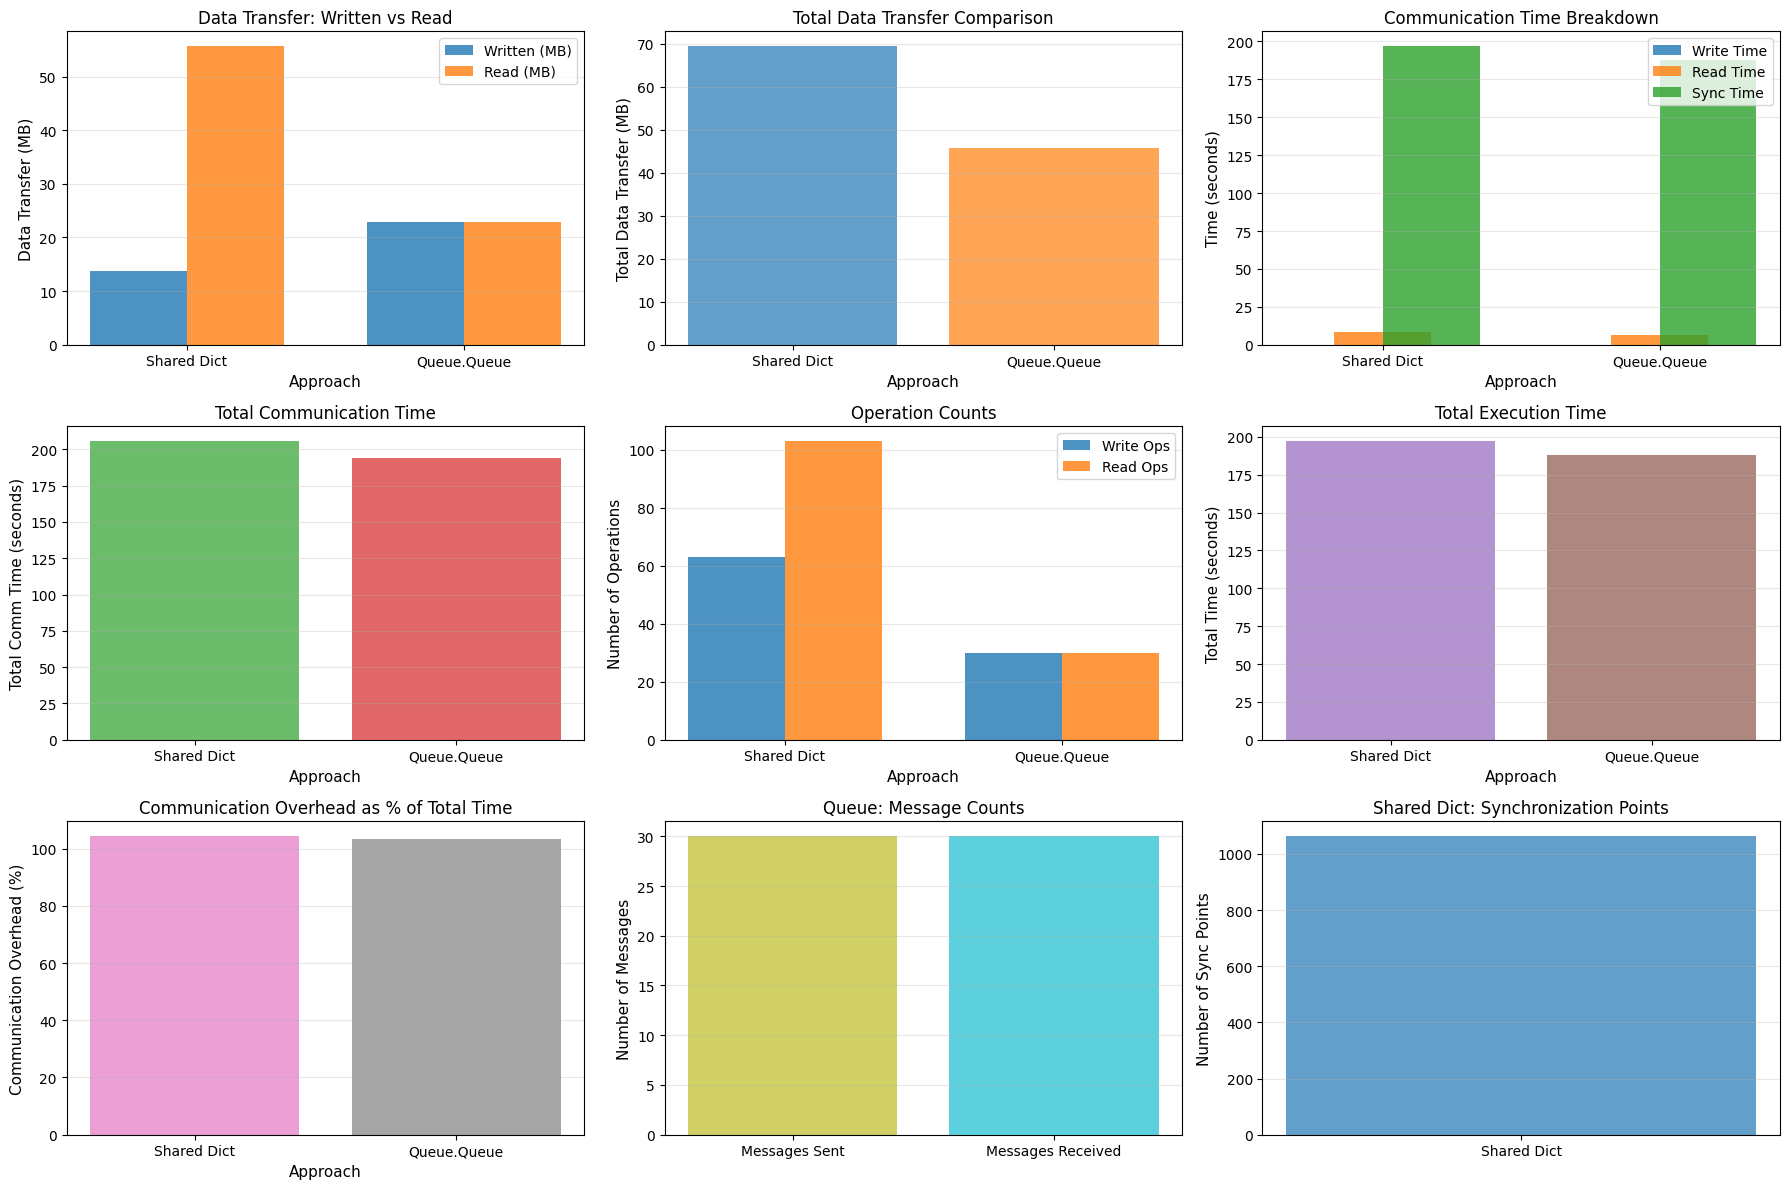

In [13]:
# Prepare data for plotting
approaches = ['Shared Dict', 'Queue.Queue']

# Data transfer metrics
bytes_written = [sd_stats['bytes_written'], q_stats['bytes_written']]
bytes_read = [sd_stats['bytes_read'], q_stats['bytes_read']]
total_bytes = [sd_stats['bytes_written'] + sd_stats['bytes_read'], 
               q_stats['bytes_written'] + q_stats['bytes_read']]

# Time metrics
write_time = [sd_stats['write_time'], q_stats['write_time']]
read_time = [sd_stats['read_time'], q_stats['read_time']]
sync_time = [sd_stats['sync_time'], q_stats['sync_time']]
total_comm_time = [sd_stats['write_time'] + sd_stats['read_time'] + sd_stats['sync_time'],
                   q_stats['write_time'] + q_stats['read_time'] + q_stats['sync_time']]

# Operation counts
write_ops = [sd_stats['write_ops'], q_stats['write_ops']]
read_ops = [sd_stats['read_ops'], q_stats['read_ops']]

# Create comprehensive comparison plots
fig = plt.figure(figsize=(18, 12))

# Plot 1: Data Transfer (Bytes)
ax1 = plt.subplot(3, 3, 1)
x = np.arange(len(approaches))
width = 0.35
ax1.bar(x - width/2, [b/1024/1024 for b in bytes_written], width, label='Written (MB)', alpha=0.8)
ax1.bar(x + width/2, [b/1024/1024 for b in bytes_read], width, label='Read (MB)', alpha=0.8)
ax1.set_xlabel('Approach', fontsize=11)
ax1.set_ylabel('Data Transfer (MB)', fontsize=11)
ax1.set_title('Data Transfer: Written vs Read', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(approaches)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Total Data Transfer
ax2 = plt.subplot(3, 3, 2)
ax2.bar(approaches, [b/1024/1024 for b in total_bytes], alpha=0.7, color=['#1f77b4', '#ff7f0e'])
ax2.set_xlabel('Approach', fontsize=11)
ax2.set_ylabel('Total Data Transfer (MB)', fontsize=11)
ax2.set_title('Total Data Transfer Comparison', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Communication Time Breakdown
ax3 = plt.subplot(3, 3, 3)
ax3.bar(x - width/2, write_time, width, label='Write Time', alpha=0.8)
ax3.bar(x, read_time, width, label='Read Time', alpha=0.8)
ax3.bar(x + width/2, sync_time, width, label='Sync Time', alpha=0.8)
ax3.set_xlabel('Approach', fontsize=11)
ax3.set_ylabel('Time (seconds)', fontsize=11)
ax3.set_title('Communication Time Breakdown', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(approaches)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Total Communication Time
ax4 = plt.subplot(3, 3, 4)
ax4.bar(approaches, total_comm_time, alpha=0.7, color=['#2ca02c', '#d62728'])
ax4.set_xlabel('Approach', fontsize=11)
ax4.set_ylabel('Total Comm Time (seconds)', fontsize=11)
ax4.set_title('Total Communication Time', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Operation Counts
ax5 = plt.subplot(3, 3, 5)
ax5.bar(x - width/2, write_ops, width, label='Write Ops', alpha=0.8)
ax5.bar(x + width/2, read_ops, width, label='Read Ops', alpha=0.8)
ax5.set_xlabel('Approach', fontsize=11)
ax5.set_ylabel('Number of Operations', fontsize=11)
ax5.set_title('Operation Counts', fontsize=12)
ax5.set_xticks(x)
ax5.set_xticklabels(approaches)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Total Execution Time
ax6 = plt.subplot(3, 3, 6)
total_times = [sd_stats['total_time'], q_stats['total_time']]
ax6.bar(approaches, total_times, alpha=0.7, color=['#9467bd', '#8c564b'])
ax6.set_xlabel('Approach', fontsize=11)
ax6.set_ylabel('Total Time (seconds)', fontsize=11)
ax6.set_title('Total Execution Time', fontsize=12)
ax6.grid(True, alpha=0.3, axis='y')

# Plot 7: Communication Overhead (% of total time)
ax7 = plt.subplot(3, 3, 7)
comm_overhead_sd = (total_comm_time[0] / sd_stats['total_time']) * 100
comm_overhead_q = (total_comm_time[1] / q_stats['total_time']) * 100
ax7.bar(approaches, [comm_overhead_sd, comm_overhead_q], alpha=0.7, color=['#e377c2', '#7f7f7f'])
ax7.set_xlabel('Approach', fontsize=11)
ax7.set_ylabel('Communication Overhead (%)', fontsize=11)
ax7.set_title('Communication Overhead as % of Total Time', fontsize=12)
ax7.grid(True, alpha=0.3, axis='y')

# Plot 8: Messages (Queue only)
ax8 = plt.subplot(3, 3, 8)
if 'messages_sent' in q_stats:
    messages_data = [q_stats['messages_sent'], q_stats['messages_received']]
    ax8.bar(['Messages Sent', 'Messages Received'], messages_data, alpha=0.7, color=['#bcbd22', '#17becf'])
    ax8.set_ylabel('Number of Messages', fontsize=11)
    ax8.set_title('Queue: Message Counts', fontsize=12)
    ax8.grid(True, alpha=0.3, axis='y')

# Plot 9: Synchronization Points (Shared Dict only)
ax9 = plt.subplot(3, 3, 9)
if 'sync_points' in sd_stats:
    ax9.bar(['Shared Dict'], [sd_stats['sync_points']], alpha=0.7, color='#1f77b4')
    ax9.set_ylabel('Number of Sync Points', fontsize=11)
    ax9.set_title('Shared Dict: Synchronization Points', fontsize=12)
    ax9.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


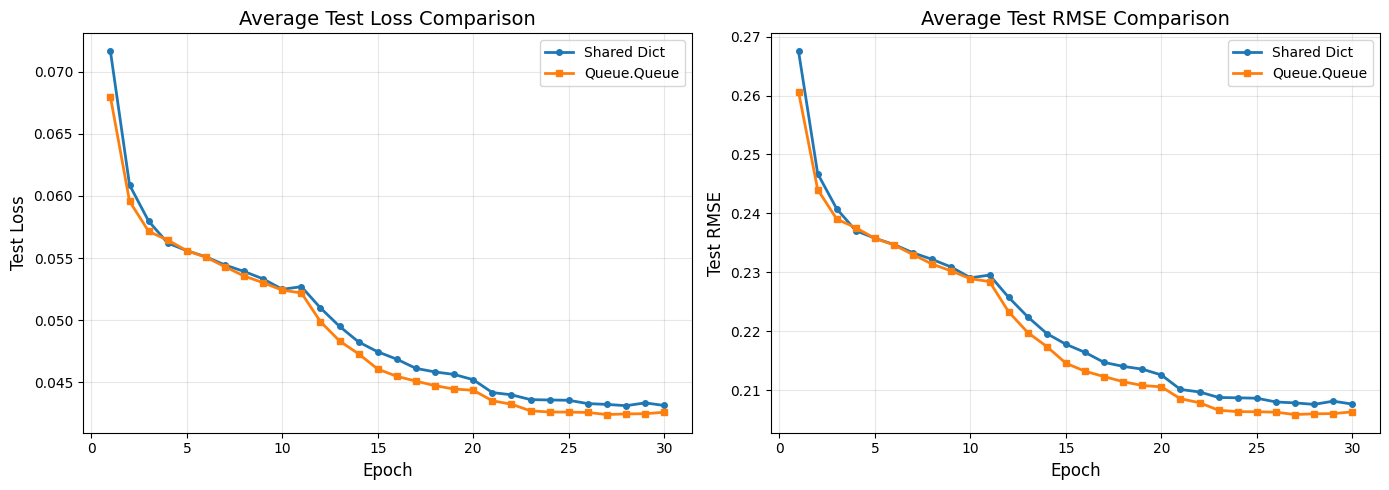

In [14]:
# Helper functions to compute aggregated metrics
def get_avg_curve(results, key):
    avg_curve = []
    for e in range(total_epochs):
        values = []
        for w in results:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):
                    values.append(val)
        avg_curve.append(np.mean(values) if values else float("nan"))
    return avg_curve

# Compute aggregated curves for both approaches
if len(shared_dict_results) > 0:
    sd_avg_test_loss = get_avg_curve(shared_dict_results, "test_losses")
    sd_avg_test_rmse = get_avg_curve(shared_dict_results, "test_rmses")
else:
    sd_avg_test_loss = []
    sd_avg_test_rmse = []

if len(queue_results) > 0:
    q_avg_test_loss = get_avg_curve(queue_results, "test_losses")
    q_avg_test_rmse = get_avg_curve(queue_results, "test_rmses")
else:
    q_avg_test_loss = []
    q_avg_test_rmse = []

# Plot training results
if len(sd_avg_test_loss) > 0 or len(q_avg_test_loss) > 0:
    x = range(1, total_epochs + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Test Loss
    ax1 = axes[0]
    if len(sd_avg_test_loss) > 0:
        ax1.plot(x, sd_avg_test_loss, marker="o", label="Shared Dict", linewidth=2, markersize=4)
    if len(q_avg_test_loss) > 0:
        ax1.plot(x, q_avg_test_loss, marker="s", label="Queue.Queue", linewidth=2, markersize=4)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Test Loss", fontsize=12)
    ax1.set_title("Average Test Loss Comparison", fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # Test RMSE
    ax2 = axes[1]
    if len(sd_avg_test_rmse) > 0:
        ax2.plot(x, sd_avg_test_rmse, marker="o", label="Shared Dict", linewidth=2, markersize=4)
    if len(q_avg_test_rmse) > 0:
        ax2.plot(x, q_avg_test_rmse, marker="s", label="Queue.Queue", linewidth=2, markersize=4)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Test RMSE", fontsize=12)
    ax2.set_title("Average Test RMSE Comparison", fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No training results available for plotting")


## Save Results


In [15]:
# Save communication comparison results
results = {
    "communication_stats": comm_stats,
    "shared_dict_results": shared_dict_results,
    "queue_results": queue_results if 'queue_results' in locals() else [],
    "config": {
        "comm_rounds": cfg.comm_rounds,
        "local_epochs": cfg.local_epochs,
        "total_epochs": total_epochs,
        "num_workers": num_workers,
        "batch_size": cfg.batch_size,
        "lr": cfg.lr,
        "emb_dim": cfg.emb_dim,
        "hidden": cfg.hidden,
        "dropout": cfg.dropout,
        "seed": cfg.seed,
        "global_n_users": global_n_users,
        "global_n_movies": global_n_movies,
    },
    "metadata": {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    }
}

with open("communication_comparison_results.pkl", "wb") as f:
    pickle.dump(results, f)

print(f"✓ Results saved to communication_comparison_results.pkl")


✓ Results saved to communication_comparison_results.pkl
